# Water vapor retrieval using principal components

This notebook provides an example of a passive microwave water vapor (WV) retrieval using ARTS.

Authors: Simon Pfreundschuh and David Duncan, Chalmers University

# Set up ARTS/Python environment


In [1]:
%env ARTS_INCLUDE_PATH=/scratch/uni/u237/users/mprange/arts/controlfiles/
#%env ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
%env ARTS_BUILD_PATH=/scratch/uni/u237/users/mprange/arts/build/
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from typhon.arts.workspace import Workspace, arts_agenda
ws = Workspace(verbosity = 0)
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

env: ARTS_INCLUDE_PATH=/scratch/uni/u237/users/mprange/arts/controlfiles/
env: ARTS_BUILD_PATH=/scratch/uni/u237/users/mprange/arts/build/
Loading ARTS API from: /scratch/uni/u237/users/mprange/arts/build/src/libarts_api.so


In [25]:
# (standard) emission calculation
ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )

# cosmic background radiation
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )

# standard surface agenda (i.e., make use of surface_rtprop_agenda)
ws.Copy( ws.iy_surface_agenda, ws.iy_surface_agenda__UseSurfaceRtprop )

ws.Copy( ws.surface_rtprop_agenda, ws.surface_rtprop_agenda__Specular_NoPol_ReflFix_SurfTFromt_surface )

# On the fly absorption
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__LookUpTable )
# sensor-only path
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
# no refraction
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )

In [69]:
# define absorbing species and sensor (here using metmm library, used again below)
ws.Copy(ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA)
ws.abs_speciesSet(species=["H2O, H2O-SelfContCKDMT252, H2O-ForeignContCKDMT252",
                           "O2, O2-CIAfunCKDMT100",
                           "N2, N2-CIAfunCKDMT252, N2-CIArotCKDMT252",
                           "O3",
                           "CO2, CO2-CKDMT252"])
# Read HITRAN catalog (needed for O3):
ws.abs_linesReadFromHitran("/scratch/uni/u237/data/catalogue/hitran/hitran_online/HITRAN2012.par",
                           19e12,
                           6e13) # ERROR, when using full IASI spectrum.
ws.abs_lines_per_speciesCreateFromLines()

Exception: Call to ARTS WSM abs_linesReadFromHitran failed with error: Undefined Rational in operator+

In [38]:
ws.abs_species.value

[['H2O-*-*-*', 'H2O-SelfContCKDMT252-*-*', 'H2O-ForeignContCKDMT252-*-*'],
 ['O2-*-*-*', 'O2-CIAfunCKDMT100-*-*'],
 ['N2-*-*-*', 'N2-CIAfunCKDMT252-*-*', 'N2-CIArotCKDMT252-*-*'],
 ['O3-*-*-*'],
 ['CO2-*-*-*', 'CO2-CKDMT252-*-*']]

# General Settings

In [8]:
ws.stokes_dim = 1
ws.jacobian_quantities = []
ws.iy_unit = "PlanckBT"
ws.cloudboxOff()

# Atmosphere set up

In [9]:
ws.atmosphere_dim = 1  # for 1DVAR
p = np.array([1000.,975.,950.,925.,900.,850.,800.,750.,700.,650.,600.,550.,500.,400.,300.,200.,100.])*100.0
ws.p_grid = 0.5 * (p[1:] + p[:-1])
ws.AtmRawRead( basename = "testdata/tropical") #tropical atmosphere assumed
ws.lat_grid = []
ws.lon_grid = []
ws.AtmFieldsCalc()
ws.AbsInputFromAtmFields()

ws.z_surface = np.asarray(ws.z_field)[0]
ws.t_surface = np.asarray(ws.t_field)[0]

No handles with labels found to put in legend.


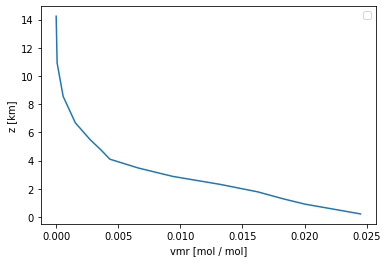

In [10]:
alt = np.asarray(ws.z_field).ravel() * .001 # altitude in km (for plotting)
plt.xlabel("T [K]")
plt.ylabel("z [km]")
plt.plot(np.asarray(ws.vmr_field)[0,:,0,0], alt)
plt.xlabel("$H_2O [mol/mol$]")
plt.ylabel("z [km]")
plt.xlabel("vmr [mol / mol]")
plt.ylabel("z [km]")
plt.legend()

In [37]:
ws.jacobianAddAbsSpecies


*-------------------------------------------------------------------*
Workspace method = jacobianAddAbsSpecies
---------------------------------------------------------------------

Includes an absorption species in the Jacobian.

For 1D or 2D calculations the latitude and/or longitude grid of
the retrieval field should set to have zero length.

There are two possible calculation methods:
   "analytical"   : (semi-)analytical expressions are used
   "perturbation" : pure numerical perturbations are used

These retrieval units are at hand for all gas species:
   "vmr"    : Volume mixing ratio.
   "nd"     : Number density.
   "rel"    : Relative unit (e.g. 1.1 means 10% more of the gas).

For water vapour, also these units are at hand:
   "rh"     : Relative humidity.
   "q"      : Specific humidity.

For perturbation calculations the size of the perturbation is set
by the user. The unit for the perturbation is the same as for the
retrieval unit.

Note that *for_species_tag* is used to

# Sensor definition

In [15]:
ws.sensor_pos  = np.array([[850e3]]) # 850km
ws.sensor_time = np.array([0.0])
ws.sensor_los  = np.array([[180.0]]) # nadir viewing

# The below lines are important to select frequency range and resolution.
# Grid spacing and FWHM of the Gaussian response should match!
ws.VectorLinSpace( ws.f_grid, 40e12, 63e12, 7.5e9 )
# load external f_backend
ws.ReadXML( ws.f_backend, "sensor_specs/IASI/f_backend.xml" )
ws.VectorCreate("f_backend_width")
ws.ReadXML( ws.f_backend_width, "sensor_specs/IASI/f_backend_width.xml" )
ws.backend_channel_responseGaussian(ws.f_backend_width)
# Sensor settings
ws.FlagOn( ws.sensor_norm )
ws.AntennaOff()
ws.sensor_responseInit()
ws.sensor_responseBackend()
ws.sensor_checkedCalc()

#ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
#ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_atms.arts")
#ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts")
#ws.execute_controlfile("instruments/metmm/common_metmm.arts")

In [14]:
ws.sensor_response_f_grid.value

array([4.30000e+13, 4.30075e+13, 4.30150e+13, ..., 5.99800e+13,
       5.99875e+13, 5.99950e+13])

In [16]:
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.abs_xsec_agenda_checkedCalc()
ws.abs_lookupSetup()
ws.abs_lookupCalc()

## Setup perturbed profile

In [17]:
a_priori = np.copy(ws.vmr_field.value[0, :, 0, 0])
perturbed = 1.4 * a_priori

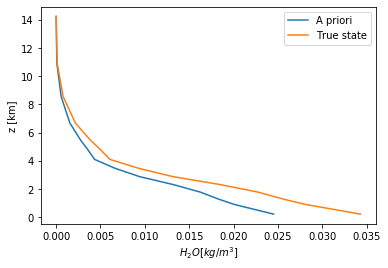

In [18]:
plt.figure()
plt.plot(a_priori, alt, label="A priori")
plt.plot(perturbed, alt, label="True state")
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")
plt.legend()

# Surface 

In [21]:
ws.surface_scalar_reflectivity = np.array([0.5]) # nominal albedo for surface
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()
ws.sensor_checkedCalc()
ws.jacobianOff()

# Call forward model

Simulate observation setting vmr_field to the perturbed WV profile.

In [62]:
ws.vmr_field.value[0, :, 0, 0] = perturbed
ws.yCalc()
ws.y.value # write out TBs for first ycalc
# ws.y.value += np.random.normal(size=ws.y.value.size)*10

array([252.26361483, 250.63227323, 249.02931662, ..., 287.30492181,
       286.44259167, 288.40174176])

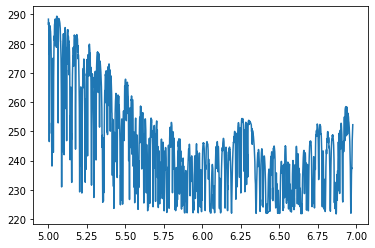

In [63]:
plt.plot(10**6*3*10**8/ws.sensor_response_f_grid.value, ws.y.value)

# Set up OEM retrieval

In [64]:
ws.vmr_field.value[0, :, 0, 0] = a_priori
ws.retrievalDefInit()
# Add H2O as retrieval quantity.
ws.retrievalAddAbsSpecies(species="H2O, H2O-SelfContCKDMT252, H2O-ForeignContCKDMT252",
                          unit="rel",
                          g1=ws.p_grid,
                          g2=ws.lat_grid,
                          g3=ws.lon_grid )
ws.covmat_sxAddBlock(block = np.diag(0.2 ** 2 * np.ones(perturbed.size)))

# Setup observation error covariance matrix.
ws.covmat_seAddBlock(block = 1.0 ** 2 * np.diag(np.ones(ws.y.value.size)))
ws.retrievalDefClose()

# define inversion iteration as function object within python
@arts_agenda
def inversion_agenda(ws):
    ws.Ignore(ws.inversion_iteration_counter)
    ws.x2artsAtmAndSurf()
    ws.atmfields_checkedCalc()  # to be safe, rerun checks dealing with atmosph.
    ws.atmgeom_checkedCalc()
    ws.yCalc()  # calculate yf and jacobian matching x
    ws.Copy(ws.yf, ws.y)
    ws.jacobianAdjustAndTransform()
    
ws.Copy(ws.inversion_iterate_agenda, inversion_agenda)

In [65]:
ws.xa = np.ones(perturbed.size) # if supplying user-defined a priori vector
ws.x  = np.array([]) # create empty vector for retrieved state vector?
ws.yf = np.array([]) # create empty vector for simulated TB?
ws.jacobian = np.array([[]])

# Run OEM retrieval

In [66]:
ws.oem_errors = []
ws.OEM(method="gn",
       max_iter=1000,
       display_progress=1,
       max_start_cost=1e5)
print(ws.oem_errors.value)
ws.x2artsAtmAndSurf() # convert from ARTS coords back to user-defined grid

ARTS[94150449651152]: 
ARTS[94150449651152]:                                 MAP Computation                                
ARTS[94150449651152]: Formulation: Standard
ARTS[94150449651152]: Method:      Gauss-Newton
ARTS[94150449651152]: 
ARTS[94150449651152]:  Step     Total Cost         x-Cost         y-Cost    Conv. Crit.               
ARTS[94150449651152]: --------------------------------------------------------------------------------
ARTS[94150449651152]:     0        5.50782              0        5.50782               
ARTS[94150449651152]:     1       0.132527      0.0135715       0.118955        777.981
ARTS[94150449651152]:     2      0.0184529      0.0166957     0.00175712        16.1785
ARTS[94150449651152]:     3      0.0183795       0.016731      0.0016485      0.0104028
ARTS[94150449651152]:     4      0.0183795      0.0167303     0.00164921     1.9853e-07
ARTS[94150449651152]: --------------------------------------------------------------------------------
ARTS[941504

In [67]:
retrieved = np.copy(ws.vmr_field)[0,:,0,0]
ws.x.value

array([1.03096426, 1.05767019, 1.05872491, 1.08470098, 1.1594476 ,
       1.26238979, 1.34798966, 1.38736009, 1.4237627 , 1.38141433,
       1.38518341, 1.42439987, 1.39391558, 1.39990401, 1.40984962,
       1.01324894])

# Look at results

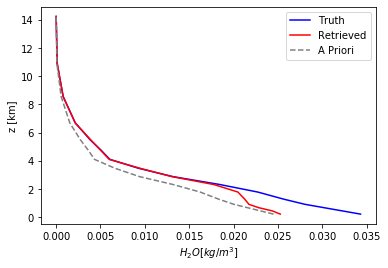

In [68]:
plt.plot(perturbed, alt, label = "Truth", c = "blue")
plt.plot(retrieved, alt, label = "Retrieved", c = "red")
plt.plot(a_priori, alt, label="A Priori", c = "grey", ls = "--")
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")
plt.legend()